# Modelado — Clasificación de Viabilidad (tabular)
Notebook para entrenamiento, validación y selección del mejor modelo con datos tabulares procesados.

**Entrada:** `data/processed/startups_sintetico_1000_processed.csv`

**Métricas:** ROC AUC (principal), F1, Precisión, Recall, Accuracy.


In [1]:
# === Imports y setup ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

def find_project_root(start: Path = None) -> Path:
    p = start or Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "raw").exists():
            return cand
    raise FileNotFoundError("No se encontró la carpeta 'data/raw' en la jerarquía del proyecto.")

PROJECT_ROOT = find_project_root()
processed_path = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_1000_processed.csv"
assert processed_path.exists(), "No se encuentra el procesado. Ejecuta el notebook de exploración/limpieza primero."
df = pd.read_csv(processed_path, encoding="utf-8")
print(df.shape)
df.head(3)

(1000, 51)


,monto_financiado,num_rondas,tamano_equipo,exp_fundadores,presencia_redes,inversores_destacados,descripcion,tiempo_fundacion,viabilidad,flag_na_monto_financiado,...,ubicacion_trujillo,estado_operativo_activo,estado_operativo_cerrado,estado_operativo_en pausa,estado_operativo_nan,estado_operativo_prototipo,antiguedad_bucket_0-1,antiguedad_bucket_2-3,antiguedad_bucket_4-7,antiguedad_bucket_8+
0,1555000.0,2.0,49.0,8.7,8.5,0.0,equipo con 8+ años de experiencia. operando en...,2016.0,1,0,...,False,True,False,False,False,False,False,False,False,True
1,4217000.0,1.0,9.0,1.2,-5.0,0.0,operando en el mercado,2007.0,1,0,...,False,True,False,False,False,False,False,False,False,True
2,1224000.0,5.0,17.0,2.5,77.3,0.0,buena presencia en redes. operando en el merca...,2019.0,1,0,...,False,True,False,False,False,False,False,False,True,False


In [2]:
# === Preparación de X, y robusta (convierte sector_x_estado si es texto y filtra solo numéricas) ===
TARGET_COL = "viabilidad"
assert TARGET_COL in df.columns, "Falta la columna objetivo 'viabilidad'"

# 1) One-hot SOLO si 'sector_x_estado' quedó como object (evita re-encodar lo ya dummificado)
if "sector_x_estado" in df.columns and df["sector_x_estado"].dtype == "object":
    dummies_sxe = pd.get_dummies(df["sector_x_estado"], prefix="sector_x_estado", drop_first=False)
    df = pd.concat([df.drop(columns=["sector_x_estado"]), dummies_sxe], axis=1)
    print(f"One-hot aplicado a 'sector_x_estado' -> {dummies_sxe.shape[1]} columnas nuevas.")

# 2) El tabular NO usa 'descripcion'
drop_cols = [TARGET_COL]
if "descripcion" in df.columns:
    drop_cols.append("descripcion")

X_all = df.drop(columns=drop_cols)

# 3) Mantener SOLO columnas numéricas (bloquea cualquier object que haya quedado)
obj_cols = X_all.select_dtypes(include=["object"]).columns.tolist()
if obj_cols:
    print("⚠️ Columnas object excluidas del tabular:", obj_cols)

num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
X = X_all[num_cols].copy()
y = df[TARGET_COL].astype(int)

print("X shape:", X.shape, "| y shape:", y.shape, "| Num cols:", len(num_cols))
print("✔️ Solo dtypes numéricos:", set(X.dtypes.unique()))


One-hot aplicado a 'sector_x_estado' -> 46 columnas nuevas.
X shape: (1000, 18) | y shape: (1000,) | Num cols: 18
✔️ Solo dtypes numéricos: {dtype('float64'), dtype('int64')}


In [3]:
# === Partición 70/15/15 y CV ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)
print("Splits ->", X_train.shape, X_valid.shape, X_test.shape)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(clf, Xv, yv, name="model"):
    # scores probabilísticos
    if hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(Xv)[:,1]
    elif hasattr(clf, "decision_function"):
        scores = clf.decision_function(Xv)
    else:
        scores = clf.predict(Xv)
    yhat = (scores >= 0.5).astype(int)
    metrics = {
        "roc_auc": roc_auc_score(yv, scores),
        "f1": f1_score(yv, yhat),
        "precision": precision_score(yv, yhat, zero_division=0),
        "recall": recall_score(yv, yhat),
        "accuracy": accuracy_score(yv, yhat),
    }
    print(f"[{name}] AUC={metrics['roc_auc']:.3f} | F1={metrics['f1']:.3f} | P={metrics['precision']:.3f} | R={metrics['recall']:.3f} | Acc={metrics['accuracy']:.3f}")
    return metrics


Splits -> (700, 18) (150, 18) (150, 18)


## Baselines

In [4]:
dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE).fit(X_train, y_train)
_ = evaluate_model(dummy, X_valid, y_valid, "Dummy")

logit = Pipeline([("scaler", StandardScaler(with_mean=False)),
                  ("clf", LogisticRegression(max_iter=250, random_state=RANDOM_STATE))]).fit(X_train, y_train)
_ = evaluate_model(logit, X_valid, y_valid, "LogReg")

[Dummy] AUC=0.490 | F1=0.584 | P=0.565 | R=0.605 | Acc=0.507
[LogReg] AUC=0.620 | F1=0.687 | P=0.615 | R=0.779 | Acc=0.593


## Modelos candidatos

In [5]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE).fit(X_train, y_train)
_ = evaluate_model(tree, X_valid, y_valid, "DecisionTree")

rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
_ = evaluate_model(rf, X_valid, y_valid, "RandomForest")

hgb = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.1, random_state=RANDOM_STATE).fit(X_train, y_train)
_ = evaluate_model(hgb, X_valid, y_valid, "HGB")

[DecisionTree] AUC=0.504 | F1=0.549 | P=0.577 | R=0.523 | Acc=0.507
[RandomForest] AUC=0.560 | F1=0.652 | P=0.612 | R=0.698 | Acc=0.573
[HGB] AUC=0.565 | F1=0.621 | P=0.614 | R=0.628 | Acc=0.560


## Comparación con CV (ROC AUC)

In [6]:
for name, model in {"LogReg":logit, "Tree":tree, "RF":rf, "HGB":hgb}.items():
    scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    print(f"{name:7s} CV AUC: {scores.mean():.3f} ± {scores.std():.3f}")

LogReg  CV AUC: 0.627 ± 0.042
Tree    CV AUC: 0.520 ± 0.038
RF      CV AUC: 0.597 ± 0.052
HGB     CV AUC: 0.565 ± 0.029


## Tuning básico

In [7]:
# HGB: RandomizedSearch liviano
param_dist_hgb = {
    "learning_rate":[0.03,0.05,0.1,0.2],
    "max_depth":[None,3,5,7],
    "l2_regularization":[0.0,0.1,0.5,1.0],
    "max_iter":[200,300,500]
}
rs_hgb = RandomizedSearchCV(HistGradientBoostingClassifier(random_state=RANDOM_STATE),
                            param_distributions=param_dist_hgb, n_iter=20, scoring="roc_auc",
                            cv=cv, random_state=RANDOM_STATE, n_jobs=-1)
rs_hgb.fit(X_train, y_train)
print("Best HGB:", rs_hgb.best_params_)
_ = evaluate_model(rs_hgb.best_estimator_, X_valid, y_valid, "HGB_tuned")

# RF: Grid pequeño
param_grid_rf = {"n_estimators":[200,400], "max_depth":[None,6,12], "max_features":["sqrt",0.5]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                     param_grid=param_grid_rf, scoring="roc_auc", cv=cv, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("Best RF:", gs_rf.best_params_)
_ = evaluate_model(gs_rf.best_estimator_, X_valid, y_valid, "RF_tuned")

Best HGB: {'max_iter': 200, 'max_depth': 3, 'learning_rate': 0.05, 'l2_regularization': 0.5}
[HGB_tuned] AUC=0.558 | F1=0.638 | P=0.588 | R=0.698 | Acc=0.547
Best RF: {'max_depth': 6, 'max_features': 0.5, 'n_estimators': 200}
[RF_tuned] AUC=0.581 | F1=0.660 | P=0.600 | R=0.733 | Acc=0.567


## Selección final y evaluación en test

[HGB_tuned] AUC=0.558 | F1=0.638 | P=0.588 | R=0.698 | Acc=0.547
[RF_tuned] AUC=0.581 | F1=0.660 | P=0.600 | R=0.733 | Acc=0.567
Mejor en valid: RF_tuned AUC=0.581
=== Test @0.5 ===
AUC: 0.7034883720930232
F1: 0.723404255319149 Prec: 0.6666666666666666 Rec: 0.7906976744186046 Acc: 0.6533333333333333
Matriz de confusión
 [[30 34]
 [18 68]]


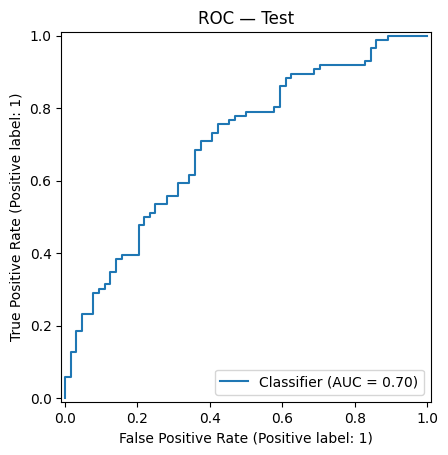

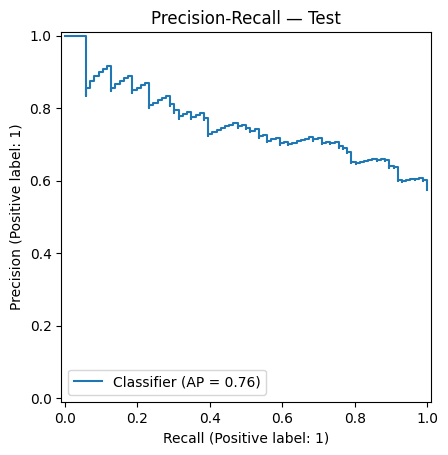

In [8]:
finals = {"HGB_tuned": rs_hgb.best_estimator_, "RF_tuned": gs_rf.best_estimator_}
best_name, best_model, best_auc = None, None, -np.inf
for name, m in finals.items():
    met = evaluate_model(m, X_valid, y_valid, name)
    if met["roc_auc"] > best_auc:
        best_auc, best_name, best_model = met["roc_auc"], name, m

print(f"Mejor en valid: {best_name} AUC={best_auc:.3f}")

# Reentrena con train+valid
best_model.fit(pd.concat([X_train,X_valid]), pd.concat([y_train,y_valid]))

# Test
if hasattr(best_model, "predict_proba"):
    scores_test = best_model.predict_proba(X_test)[:,1]
elif hasattr(best_model, "decision_function"):
    scores_test = best_model.decision_function(X_test)
else:
    scores_test = best_model.predict(X_test)

y_pred05 = (scores_test>=0.5).astype(int)

print("=== Test @0.5 ===")
print("AUC:", roc_auc_score(y_test, scores_test))
print("F1:", f1_score(y_test, y_pred05), "Prec:", precision_score(y_test, y_pred05), "Rec:", recall_score(y_test, y_pred05), "Acc:", accuracy_score(y_test, y_pred05))
print("Matriz de confusión\n", confusion_matrix(y_test, y_pred05))

# Curvas
_ = RocCurveDisplay.from_predictions(y_test, scores_test)
plt.title("ROC — Test")
plt.show()

_ = PrecisionRecallDisplay.from_predictions(y_test, scores_test)
plt.title("Precision-Recall — Test")
plt.show()